# Проектная работа: Рекомендация тарифов

## Описание проекта
Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. **Целью данной работы** является построение модели для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — она уже сделана.

**Примечание**: необходимо построить модель с максимально большим значением accuracy (необходимо довести долю правильных ответов по крайней мере до 0.75). Проверка `accuracy` должна быть проведена на тестовой выборке.

**Описание данных**:
- `calls` - количество звонков;
- `minutes` - суммарная длительность звонков в минутах;
- `messages` - количество sms-сообщений;
- `mb_used` - израсходованный интернет-трафик в Мб;
- `is_ultra` - каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

**План работы**:
1. Открытие таблицы и изучение общей информации о данных;
2. Разделение исходные данные на обучающую, валидационную и тестовую выборки;
3. Исследование качества разных моделей;
4. Проверка качества модели на тестовой выборке.

### Шаг 1. Открытие таблицы и изучение общей информации о данных

In [1]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("users_behavior.csv")
format_mapping = {"calls" : "{:.0f}", "minutes" : "{:,.2f}", "messages" : "{:.0f}", "mb_used" : "{:,.2f}", 
                  "is_ultra" : "{:.0f}"}
df.head().style.format(format_mapping)

,calls,minutes,messages,mb_used,is_ultra
0,40,311.90,83,"19,915.42",0
1,85,516.75,56,"22,696.96",0
2,77,467.66,86,"21,060.45",0
3,106,745.53,81,"8,437.39",1
4,66,418.74,1,"14,502.75",0


In [3]:
df.shape

(3214, 5)

In [4]:
df.columns

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

In [5]:
df.dtypes

calls       float64
minutes     float64
messages    float64
mb_used     float64
is_ultra      int64
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


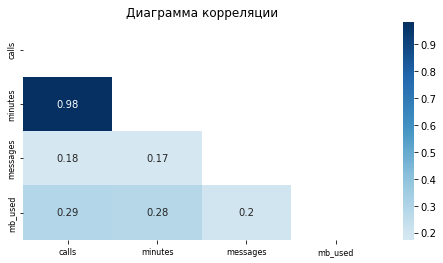

In [7]:
# в данных между фичами может быть линейная зависимость
# проверим корреляции, построив диаграмму корреляции
correlation = df[["calls", "minutes", "messages", "mb_used"]].corr()
triangle = np.triu(correlation)

plt.figure(figsize = (8, 4))
sns.heatmap(correlation, xticklabels = correlation.columns, yticklabels = correlation.columns, 
            cmap = "RdBu", center = 0, annot = True, mask = triangle) 

plt.title('Диаграмма корреляции', fontsize = 12)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.show()

<Figure size 800x640 with 0 Axes>

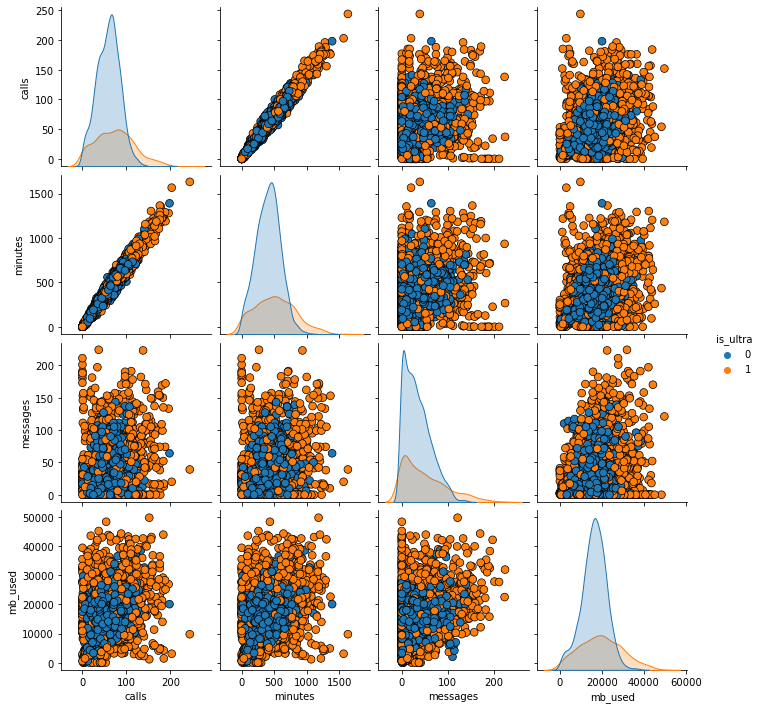

In [8]:
# парный график тоже помогает выявить линейную связь
plt.figure(figsize = (10, 8), dpi = 80)
sns.pairplot(df, kind = "scatter", hue = "is_ultra", plot_kws = dict(s = 60, edgecolor = "black", linewidth = .7))
plt.show()

### Выводы
---
1. Качество предоставленного набора данных - высокое. Предобработка не требуется:
    - Тип данных в каждой колонке совпадает с логикой тех данных, которые представлены в этой колонке.
    - Пропущенные строки отсутствуют.
2. Объем данных относительно небольшой - чуть больше 3 тыс. строк.
3. Целевым признаком является колонка `is_ultra`.
4. В наборе данных есть два признака, между которыми существует высокая линейная зависимость, а именно: корреляция между `calls` и `minutes` равняется 0.98. Данная связь также подтверждается на парном графике, где значения calls и minutes фактические сливаются. Это означает наличие мультиколлинеарности. При оценке моделей необходимо учесть данный фактор, удалив один из этих признаков в наших выборках.

### Шаг 2. Разделение исходные данные на обучающую, валидационную и тестовую выборки

In [9]:
# 60% данных - обучающая выборка
df_train, temp = train_test_split(df, test_size = 0.4, random_state = 12345)
# валидационная и тестовые выборки - по 20% от всех данных
df_valid, df_test = train_test_split(temp, test_size = 0.5, random_state = 12345)

print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(1928, 5)
(643, 5)
(643, 5)


In [10]:
# выделим в каждой выборке обучающие признаки и целевой признак
# из-за мультиколлинеарности удаляем признак calls
features_train = df_train.drop(["is_ultra", "calls"], axis = 1)
target_train = df_train["is_ultra"]

features_valid = df_valid.drop(["is_ultra", "calls"], axis = 1)
target_valid = df_valid["is_ultra"]

features_test = df_test.drop(["is_ultra", "calls"], axis = 1)
target_test = df_test["is_ultra"]

### Выводы
---
Предоставленный набор данных поделен на  обучающую, валидационную и тестовую выборки. В каждой выборке выделены обучающие празнаки и отдельно целевой признак. Признак `calls` пришлось удалить из набора признаков, чтобы исключить мультиколлинеарность в данных. Подготовительная работа к исследованию разных моделей выполнена.

### Шаг 3. Исследование качества разных моделей

##### 3.1. Дерево решений

In [11]:
best_model = None
best_accuracy = 0
max_depth = 0

for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    accuracy = accuracy_score(predictions, target_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        max_depth = depth
 
print(f"Качество лучшей модели: {best_accuracy.round(4)}", 
      f"Максимальная глубина лучшей модели: {max_depth}", sep = "\n")

Качество лучшей модели: 0.7885
Максимальная глубина лучшей модели: 4


##### 3.2. Алгоритм случайного леса

In [12]:
best_model = None
best_accuracy = 0
best_est = 0

for est in range(10, 201, 10):
    model = RandomForestClassifier(random_state = 12345, n_estimators = est)
    model.fit(features_train, target_train)
    accuracy = model.score(features_valid, target_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_est = est

print(f"Качество лучшей модели: {best_accuracy.round(4)}", 
      f"Число деревьев в лучшей модели: {best_est}", sep = "\n")

Качество лучшей модели: 0.7838
Число деревьев в лучшей модели: 180


##### 3.3. Логистическая регрессия

In [13]:
best_model = None
best_accuracy = 0
best_iter = 0

for iter in range(100, 1001, 50):
    model = LogisticRegression(random_state = 12345, solver = "lbfgs", max_iter = iter)
    model.fit(features_train, target_train)
    accuracy = model.score(features_valid, target_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_iter = iter

print(f"Качество лучшей модели: {best_accuracy.round(4)}", 
      f"Максимальное количество итераций: {best_iter}", sep = "\n")

Качество лучшей модели: 0.7076
Максимальное количество итераций: 100


### Выводы
---
На обучающей выборке качество свыше 0.75 удалось получить благодаря алгоритмам дерева решений и случайного леса - 0.7885 и 0.7838, соответственно. Разница между качествами данных моделей небольшая, но все же она есть. Поэтому на тестовой выборке проверим модель, построенную алгоритмом случайного леса, у которой глубина - 4. Модель на основе логистической регрессии хуже остальных справилась с задачей, ее качество составило 0.7076, что ниже целевого уровня качества модели.

### Шаг 4. Проверка качества модели на тестовой выборке

##### 4.1. Тестирование решающего дерева

In [14]:
model = DecisionTreeClassifier(random_state = 12345, max_depth = 4)
model.fit(features_train, target_train)
result = model.score(features_test, target_test)
print(f"Качество модели: {result.round(4)}")

Качество модели: 0.7807


### Выводы
---
На тестовой выборке алгоритм решающего дерева подтвердил качество модели, хотя и результат немного упал по сравнению с результатом, полученным на обучающей выборке. Тем не менее, целевой показатель качества модели в 0.75 превышен, а, значит, задача выполнена.